In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import boxcox
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import pymongo
import os ,sys 

if os.path.abspath('../') not in sys.path:
    sys.path.insert(0, os.path.abspath('../'))

In [2]:
# Open connection from mongoDB
database_username = "admin01"
database_password = "LZRKfNnjX38rCOMs"
database_cluster_name = "bigdataforengineering.wef2a2d.mongodb.net"
connection_string = f"mongodb+srv://{database_username}:{database_password}@{database_cluster_name}/?retryWrites=true&w=majority"

database_name = 'processed_data' 
client = pymongo.MongoClient(connection_string)

# Check if the connection was successful
if client.server_info():
    print("Connected to MongoDB successfully!")

Connected to MongoDB successfully!


In [3]:
db = client[database_name]

In [4]:
weather_collection = 'vie_weather'
weather_collection = db[weather_collection]
weather_cursor = weather_collection.find({})
weather_list = list(weather_cursor)
Vie_weather = pd.DataFrame(weather_list)

In [5]:
carbon_forest_collection = 'carbon_forest'
carbon_forest_collection = db[carbon_forest_collection]
cdf_cursor = carbon_forest_collection.find({})
carbon_deforest_list = list(cdf_cursor)
forest_carbon = pd.DataFrame(carbon_deforest_list) 

In [6]:
econ_collection = 'economic_indicators'
econ_collection = db[econ_collection]
econ_cursor = econ_collection.find({})
economic_list = list(econ_cursor)
economic = pd.DataFrame(economic_list)


In [7]:
economic['province'] = economic['province'].str.upper()
forest_carbon['province'] = forest_carbon['province'].str.upper()
Vie_weather['province'] = Vie_weather['province'].str.upper()

In [8]:
print('columns for economic dataset:\n',economic.columns)
print('columns for weather dataset:\n',Vie_weather.columns)
print('columns for deforestation dataset:\n',forest_carbon.columns)

columns for economic dataset:
 Index(['_id', 'province', 'year', 'AREA OF LAND (Thous. ha)',
       'POPULATION (Thous. pers.)', 'POPULATION DENSITY (Person/km2)',
       'At current prices (Bill. dongs)', 'State budget revenue (Bill. dongs)',
       'State budget expenditure (Bill. dongs)',
       'Investment at current prices (Bill. dongs)', 'Number of farms',
       'Planted area of cereals (Thous. ha)', 'Production of fishery (Ton)',
       'Index of industrial production (%)',
       'Retail sales of goods at current prices (Bill. dongs)',
       'Number of schools (School)',
       'Number of medical establishments (Esta.)'],
      dtype='object')
columns for weather dataset:
 Index(['_id', 'temp', 'temp_min', 'sunrise', 'sunset', 'description',
       'humidity', 'pressure', 'feels_like', 'temp_max', 'wind', 'province'],
      dtype='object')
columns for deforestation dataset:
 Index(['_id', 'carbon_gross_emissions', 'tc_loss_ha', 'year', 'province'], dtype='object')


In [9]:
economic

,_id,province,year,AREA OF LAND (Thous. ha),POPULATION (Thous. pers.),POPULATION DENSITY (Person/km2),At current prices (Bill. dongs),State budget revenue (Bill. dongs),State budget expenditure (Bill. dongs),Investment at current prices (Bill. dongs),Number of farms,Planted area of cereals (Thous. ha),Production of fishery (Ton),Index of industrial production (%),Retail sales of goods at current prices (Bill. dongs),Number of schools (School),Number of medical establishments (Esta.)
0,65a2a93ef3e0636152b143cb,AN GIANG,2015,353.7,2000.9,566.0,60466.8,13141.9,17687.6,11228.7,697.0,652.8,348079.0,105.0,35835.0,547.0,191
1,65a2a93ef3e0636152b143cc,AN GIANG,2016,353.7,1976.4,559.0,65466.9,14282.0,18002.0,11920.3,1180.0,677.1,369843.0,105.7,38093.0,542.0,192
2,65a2a93ef3e0636152b143cd,AN GIANG,2017,353.6,1954.2,553.0,70719.7,16165.1,22522.4,13488.6,1063.0,649.4,401724.0,106.8,43129.0,536.0,3560
3,65a2a93ef3e0636152b143ce,AN GIANG,2018,353.7,1931.0,546.0,78152.9,19303.5,24880.1,16146.9,1016.0,630.6,486804.0,108.9,47437.0,530.0,3807
4,65a2a93ef3e0636152b143cf,AN GIANG,2019,353.7,1907.4,539.0,84939.6,20539.3,26701.5,17695.7,966.0,632.2,539909.0,109.9,51421.0,531.0,3969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,65a2a93ef3e0636152b1457f,YEN BAI,2017,688.7,807.3,117.2,24917.8,14616.7,14413.5,10370.8,16.0,70.7,7497.0,106.9,12665.0,192.0,358
437,65a2a93ef3e0636152b14580,YEN BAI,2018,688.7,814.6,118.3,27590.4,16345.4,16025.7,11105.3,32.0,70.6,9017.0,104.3,13868.0,197.0,371
438,65a2a93ef3e0636152b14581,YEN BAI,2019,689.3,823.0,119.4,30530.1,18736.1,18480.1,13513.1,34.0,71.6,10485.0,110.9,15979.0,179.0,393
439,65a2a93ef3e0636152b14582,YEN BAI,2020,689.3,831.6,120.6,33414.8,20577.5,20472.8,15655.2,17.0,72.3,11634.0,108.1,16728.0,177.0,409


In [10]:
forest_carbon

,_id,carbon_gross_emissions,tc_loss_ha,year,province
0,65a281f78cf571a0ae35b213,24733,229,2015,AN GIANG
1,65a281f78cf571a0ae35b214,110738,904,2016,AN GIANG
2,65a281f78cf571a0ae35b215,200469,930,2017,AN GIANG
3,65a281f78cf571a0ae35b216,126319,540,2018,AN GIANG
4,65a281f78cf571a0ae35b217,34024,174,2019,AN GIANG
...,...,...,...,...,...
436,65a281f78cf571a0ae35b3c7,360933,752,2017,YEN BAI
437,65a281f78cf571a0ae35b3c8,226560,450,2018,YEN BAI
438,65a281f78cf571a0ae35b3c9,12688,63,2019,YEN BAI
439,65a281f78cf571a0ae35b3ca,970,8,2020,YEN BAI


In [11]:
Vie_weather

,_id,temp,temp_min,sunrise,sunset,description,humidity,pressure,feels_like,temp_max,wind,province
0,65a4da4429ff01c276d8d03f,301.12,301.12,1704928736,1704970342,scattered clouds,59,1009,302.45,301.12,1.95,AN GIANG
1,65a4da4429ff01c276d8d040,303.12,303.12,1704928736,1704970342,few clouds,57,1009,305.35,303.12,1.65,AN GIANG
2,65a4da4429ff01c276d8d041,300.12,300.12,1704928736,1704970342,overcast clouds,74,1012,302.29,300.12,4.09,AN GIANG
3,65a4da4429ff01c276d8d042,298.12,298.12,1704928736,1704970342,overcast clouds,84,1012,298.87,298.12,3.02,AN GIANG
4,65a4da4429ff01c276d8d043,297.12,297.12,1705015152,1705056774,broken clouds,87,1010,297.84,297.12,2.27,AN GIANG
...,...,...,...,...,...,...,...,...,...,...,...,...
436,65a4da4429ff01c276d8d1f3,291.07,291.07,1704930050,1704969292,overcast clouds,97,1018,291.45,291.07,0.90,YEN BAI
437,65a4da4429ff01c276d8d1f4,291.72,291.72,1704930050,1704969292,overcast clouds,94,1016,292.09,291.72,1.05,YEN BAI
438,65a4da4429ff01c276d8d1f5,291.19,291.19,1704930050,1704969292,overcast clouds,96,1018,291.56,291.19,0.84,YEN BAI
439,65a4da4429ff01c276d8d1f6,291.55,291.55,1704930050,1704969292,overcast clouds,95,1016,291.93,291.55,0.91,YEN BAI


In [12]:
if any(economic.index.duplicated()) or any(Vie_weather.index.duplicated()) or any(forest_carbon.index.duplicated()):
    raise ValueError("Duplicate values found in index.")

# Merge the DataFrames along axis 1
vndata = pd.concat([forest_carbon, Vie_weather, economic], axis=1)
vndata

,_id,carbon_gross_emissions,tc_loss_ha,year,province,_id,temp,temp_min,sunrise,sunset,...,State budget revenue (Bill. dongs),State budget expenditure (Bill. dongs),Investment at current prices (Bill. dongs),Number of farms,Planted area of cereals (Thous. ha),Production of fishery (Ton),Index of industrial production (%),Retail sales of goods at current prices (Bill. dongs),Number of schools (School),Number of medical establishments (Esta.)
0,65a281f78cf571a0ae35b213,24733,229,2015,AN GIANG,65a4da4429ff01c276d8d03f,301.12,301.12,1704928736,1704970342,...,13141.9,17687.6,11228.7,697.0,652.8,348079.0,105.0,35835.0,547.0,191
1,65a281f78cf571a0ae35b214,110738,904,2016,AN GIANG,65a4da4429ff01c276d8d040,303.12,303.12,1704928736,1704970342,...,14282.0,18002.0,11920.3,1180.0,677.1,369843.0,105.7,38093.0,542.0,192
2,65a281f78cf571a0ae35b215,200469,930,2017,AN GIANG,65a4da4429ff01c276d8d041,300.12,300.12,1704928736,1704970342,...,16165.1,22522.4,13488.6,1063.0,649.4,401724.0,106.8,43129.0,536.0,3560
3,65a281f78cf571a0ae35b216,126319,540,2018,AN GIANG,65a4da4429ff01c276d8d042,298.12,298.12,1704928736,1704970342,...,19303.5,24880.1,16146.9,1016.0,630.6,486804.0,108.9,47437.0,530.0,3807
4,65a281f78cf571a0ae35b217,34024,174,2019,AN GIANG,65a4da4429ff01c276d8d043,297.12,297.12,1705015152,1705056774,...,20539.3,26701.5,17695.7,966.0,632.2,539909.0,109.9,51421.0,531.0,3969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,65a281f78cf571a0ae35b3c7,360933,752,2017,YEN BAI,65a4da4429ff01c276d8d1f3,291.07,291.07,1704930050,1704969292,...,14616.7,14413.5,10370.8,16.0,70.7,7497.0,106.9,12665.0,192.0,358
437,65a281f78cf571a0ae35b3c8,226560,450,2018,YEN BAI,65a4da4429ff01c276d8d1f4,291.72,291.72,1704930050,1704969292,...,16345.4,16025.7,11105.3,32.0,70.6,9017.0,104.3,13868.0,197.0,371
438,65a281f78cf571a0ae35b3c9,12688,63,2019,YEN BAI,65a4da4429ff01c276d8d1f5,291.19,291.19,1704930050,1704969292,...,18736.1,18480.1,13513.1,34.0,71.6,10485.0,110.9,15979.0,179.0,393
439,65a281f78cf571a0ae35b3ca,970,8,2020,YEN BAI,65a4da4429ff01c276d8d1f6,291.55,291.55,1704930050,1704969292,...,20577.5,20472.8,15655.2,17.0,72.3,11634.0,108.1,16728.0,177.0,409


In [13]:
vndata = vndata.loc[:, ~vndata.columns.duplicated(keep='first')]
vndata.columns

Index(['_id', 'carbon_gross_emissions', 'tc_loss_ha', 'year', 'province',
       'temp', 'temp_min', 'sunrise', 'sunset', 'description', 'humidity',
       'pressure', 'feels_like', 'temp_max', 'wind',
       'AREA OF LAND (Thous. ha)', 'POPULATION (Thous. pers.)',
       'POPULATION DENSITY (Person/km2)', 'At current prices (Bill. dongs)',
       'State budget revenue (Bill. dongs)',
       'State budget expenditure (Bill. dongs)',
       'Investment at current prices (Bill. dongs)', 'Number of farms',
       'Planted area of cereals (Thous. ha)', 'Production of fishery (Ton)',
       'Index of industrial production (%)',
       'Retail sales of goods at current prices (Bill. dongs)',
       'Number of schools (School)',
       'Number of medical establishments (Esta.)'],
      dtype='object')

In [14]:
# drop id column
vndata = vndata.drop(['_id'],axis=1)

### Dataset Description
The dataset provides comprehensive information on various socio-economic and environmental factors across 63 provinces in Vietnam by years (from 2015-2021)
1. ```Province (string):``` Represents information on the 63 provinces and municipalities in Vietnam.
2. ```Year:``` Indicates the year in which the data was collected.
3. ```AREA OF LAND (int):```Represents the total natural land area of each province per year (in thousand hectares).
4. ```POPULATION (float):``` Signifies the total population within the geographical area (in thousand persons).
5. ```POPULATION DENSITY (float):```Measures the population density in persons per square kilometer.
6. ```GROSS REGIONAL DOMESTIC PRODUCT (GRDP) (float):```Reflects the total value of goods and services produced in the economic region each year (in billion Vietnamese dong).
7. ```State Budget Revenue (float):```Represents the total revenue collected from taxes, fees, etc., by the province in the corresponding year (in billion Vietnamese dong).
8. ```State Budget Expenditure (float):```Indicates the total amount spent by the province on programs, projects, or other activities (in billion Vietnamese dong).
9. ```Investment at Current Prices (float):```Denotes the total capital invested by businesses, organizations, or the government in a specific region, measured at current values (in billion Vietnamese dong).
10. ```Number of Farms (int):```Represents the total count of farms in the region.
11. ```Planted Area of Cereals (float):```Indicates the total land area used for cultivating cereals such as wheat or other grains (in thousand hectares).
12. ```Production of Fishery (float):```Signifies the total quantity of fisheries produced in the region (in tons).
13. ```Index of Industrial Production (float):```Measures the growth or decline of industrial production activities in the region, expressed as a percentage.
14. ```Retail Sales of Goods at Current Prices (float):```Represents the total value of goods sold at current prices in retail activities within the region (in billion Vietnamese dong).
15. ```Number of Schools (int):``` the total number of educational institutions in the region.
16. ```Number of Medical Establishments (int):``` Represents the total count of medical centers in the region.
17. ```Carbon Gross Emissions(int):```Indicates the total amount of carbon emissions released into the environment in the region (in Megaton CO2e).
18. ```tc_los_ha - Tropical Forest Loss per Hectare (Target Variable) (int):```Represents the amount of tropical forest loss per hectare in the region.
### streaming data merge
19. ``` temp```
20. ``` temp_min```
21. ``` sunrise```
22. ``` sunset```
23. ``` humidity```
24. ```pressure```
25. ``` feels_like```
26. ```temp_max```
27. ```wind```

In [15]:
provinces = vndata['province'].value_counts().sort_index()
print(provinces.index)

Index(['AN GIANG', 'BA RIA-VUNG TAU', 'BAC GIANG', 'BAC KAN', 'BAC LIEU',
       'BAC NINH', 'BEN TRE', 'BINH DINH', 'BINH DUONG', 'BINH PHUOC',
       'BINH THUAN', 'CA MAU', 'CAN THO', 'CAO BANG', 'DA NANG', 'DAK LAK',
       'DAK NONG', 'DIEN BIEN', 'DONG NAI', 'DONG THAP', 'GIA LAI', 'HA GIANG',
       'HA NAM', 'HA NOI', 'HA TINH', 'HAI DUONG', 'HAI PHONG', 'HAU GIANG',
       'HO CHI MINH CITY', 'HOA BINH', 'HUNG YEN', 'KHANH HOA', 'KIEN GIANG',
       'KON TUM', 'LAI CHAU', 'LAM DONG', 'LANG SON', 'LAO CAI', 'LONG AN',
       'NAM DINH', 'NGHE AN', 'NINH BINH', 'NINH THUAN', 'PHU THO', 'PHU YEN',
       'QUANG BINH', 'QUANG NAM', 'QUANG NGAI', 'QUANG NINH', 'QUANG TRI',
       'SOC TRANG', 'SON LA', 'TAY NINH', 'THAI BINH', 'THAI NGUYEN',
       'THANH HOA', 'THUA THIEN - HUE', 'TIEN GIANG', 'TRA VINH',
       'TUYEN QUANG', 'VINH LONG', 'VINH PHUC', 'YEN BAI'],
      dtype='object')


In [16]:
vndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 28 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   carbon_gross_emissions                                 441 non-null    int64  
 1   tc_loss_ha                                             441 non-null    int64  
 2   year                                                   441 non-null    int64  
 3   province                                               441 non-null    object 
 4   temp                                                   441 non-null    float64
 5   temp_min                                               441 non-null    float64
 6   sunrise                                                441 non-null    int64  
 7   sunset                                                 441 non-null    int64  
 8   description                                       

In [17]:
vndata.describe()

,carbon_gross_emissions,tc_loss_ha,year,temp,temp_min,sunrise,sunset,humidity,pressure,feels_like,...,State budget revenue (Bill. dongs),State budget expenditure (Bill. dongs),Investment at current prices (Bill. dongs),Number of farms,Planted area of cereals (Thous. ha),Production of fishery (Ton),Index of industrial production (%),Retail sales of goods at current prices (Bill. dongs),Number of schools (School),Number of medical establishments (Esta.)
count,4.410000e+02,441.000000,441.000000,441.000000,441.000000,4.410000e+02,4.410000e+02,441.000000,441.000000,441.000000,...,438.000000,438.000000,441.000000,437.000000,441.000000,441.000000,441.000000,427.000000,401.00000,441.000000
mean,6.949478e+06,31444.900227,2018.000000,295.187098,295.187098,1.704954e+09,1.704995e+09,82.229025,1013.791383,295.790227,...,33844.163242,24901.584932,40594.321088,475.041190,136.360930,124224.588889,109.718458,47757.697658,296.15212,336.131519
std,9.094506e+06,38863.187918,2.002271,4.494802,4.494802,5.982736e+04,5.981696e+04,13.728195,2.825536,5.042821,...,53422.606117,20327.454757,62154.561255,578.969084,143.099312,162544.028770,13.605817,75010.252918,223.55866,444.984694
min,0.000000e+00,0.000000,2015.000000,285.040000,285.040000,1.704842e+09,1.704882e+09,29.000000,1007.000000,284.280000,...,2326.700000,6039.200000,3303.700000,1.000000,4.900000,415.000000,43.000000,25.000000,81.00000,75.000000
25%,1.358410e+05,741.000000,2016.000000,291.550000,291.550000,1.704929e+09,1.704969e+09,77.000000,1011.000000,291.930000,...,12972.575000,13641.225000,14596.500000,95.000000,59.300000,9451.000000,104.800000,18305.700000,167.00000,142.000000
50%,2.804517e+06,16496.000000,2018.000000,295.080000,295.080000,1.704930e+09,1.704970e+09,85.000000,1015.000000,295.480000,...,20136.600000,20173.750000,23481.700000,304.000000,83.800000,57848.400000,108.500000,32297.500000,224.00000,212.000000
75%,1.103282e+07,48888.000000,2020.000000,297.920000,297.920000,1.705015e+09,1.705056e+09,92.000000,1016.000000,298.430000,...,30665.525000,28787.100000,39270.800000,678.000000,163.400000,181820.000000,112.800000,48777.500000,333.00000,356.000000
max,5.193177e+07,239219.000000,2021.000000,308.300000,308.300000,1.705017e+09,1.705057e+09,100.000000,1018.000000,310.910000,...,410180.000000,168232.000000,446538.000000,3830.000000,769.700000,853480.000000,278.200000,591895.000000,1374.00000,4011.000000


## rename the columns 

In [18]:
# rename columns 
vndata.rename(columns={'AREA OF LAND (Thous. ha)': 'AREA OF LAND','POPULATION (Thous. pers.)':'Population', 'POPULATION DENSITY (Person/km2)':'population density', 'At current prices (Bill. dongs)':'GROSS REGIONAL DOMESTIC PRODUCT', 
                       'State budget revenue (Bill. dongs)':'STATE BUDGET REVENUE', 'State budget expenditure (Bill. dongs)':'STATE BUDGET EXPENDITURE',
                       'Investment at current prices (Bill. dongs)': 'INVESTMENT AT CURRENT PRICES',
                       'Number of farms': 'NUMBER OF FARM', 'Planted area of cereals (Thous. ha)': 'PLANTED AREA OF CEREALS',
                       'Production of fishery (Ton)':'PRODUCTION OF FISHERY','Index of industrial production (%)': 'INDEX OF INDUSTRIAL PRODUCTION',
                       'Retail sales of goods at current prices (Bill. dongs)': 'RETAIL SALES OF GOODS', 'Number of schools (School)':'NUMBER OF SCHOOLS',
                       'Number of medical establishments (Esta.)': 'NUMBER OF MEDICAL ESTABLISHMENTS',
                       'carbon_gross_emissions': 'CARBON GROSS EMISSIONS', 'tc_loss_ha':'TROPICAL FOREST LOSS',
                       'FEELS_LIKE': 'FEELS LIKE','TEMP_MIN': 'TEMP MIN','TEMP_MAX': 'TEMP MAX'}, inplace=True)
# uppercase all columns
vndata.columns = vndata.columns.str.upper()
vndata.columns

Index(['CARBON GROSS EMISSIONS', 'TROPICAL FOREST LOSS', 'YEAR', 'PROVINCE',
       'TEMP', 'TEMP_MIN', 'SUNRISE', 'SUNSET', 'DESCRIPTION', 'HUMIDITY',
       'PRESSURE', 'FEELS_LIKE', 'TEMP_MAX', 'WIND', 'AREA OF LAND',
       'POPULATION', 'POPULATION DENSITY', 'GROSS REGIONAL DOMESTIC PRODUCT',
       'STATE BUDGET REVENUE', 'STATE BUDGET EXPENDITURE',
       'INVESTMENT AT CURRENT PRICES', 'NUMBER OF FARM',
       'PLANTED AREA OF CEREALS', 'PRODUCTION OF FISHERY',
       'INDEX OF INDUSTRIAL PRODUCTION', 'RETAIL SALES OF GOODS',
       'NUMBER OF SCHOOLS', 'NUMBER OF MEDICAL ESTABLISHMENTS'],
      dtype='object')

In [19]:
# check the NaN values 
vndata.isnull().sum()

CARBON GROSS EMISSIONS               0
TROPICAL FOREST LOSS                 0
YEAR                                 0
PROVINCE                             0
TEMP                                 0
TEMP_MIN                             0
SUNRISE                              0
SUNSET                               0
DESCRIPTION                          0
HUMIDITY                             0
PRESSURE                             0
FEELS_LIKE                           0
TEMP_MAX                             0
WIND                                 0
AREA OF LAND                        19
POPULATION                           0
POPULATION DENSITY                  16
GROSS REGIONAL DOMESTIC PRODUCT      1
STATE BUDGET REVENUE                 3
STATE BUDGET EXPENDITURE             3
INVESTMENT AT CURRENT PRICES         0
NUMBER OF FARM                       4
PLANTED AREA OF CEREALS              0
PRODUCTION OF FISHERY                0
INDEX OF INDUSTRIAL PRODUCTION       0
RETAIL SALES OF GOODS    

### now, we fill the NaN values by the mean in each provinces
- The retail sail of goods data for Thanh Hoa and Quang tri is missing, so I will fill them by the mean of the country

In [20]:
columns_to_fill = ['AREA OF LAND', 'POPULATION DENSITY', 'GROSS REGIONAL DOMESTIC PRODUCT',
                   'STATE BUDGET REVENUE', 'STATE BUDGET EXPENDITURE', 'NUMBER OF FARM',
                   'RETAIL SALES OF GOODS', 'NUMBER OF SCHOOLS']

# Group by province and calculate the mean for each specified column
mean_values_by_province = vndata.groupby('PROVINCE')[columns_to_fill].mean()
# Iterate over each column to fill missing values with the respective province's mean and round to 2 decimal places
for col in columns_to_fill:
    vndata[col] = vndata.apply(lambda row: round(row[col], 2) if pd.notnull(row[col]) else round(mean_values_by_province.loc[row['PROVINCE'], col], 2), axis=1)
# Fill NaN values in 'RETAIL SALES OF GOODS' with the mean of the column
vndata['RETAIL SALES OF GOODS'].fillna(vndata['RETAIL SALES OF GOODS'].mean(), inplace=True)
vndata.isnull().sum()


CARBON GROSS EMISSIONS              0
TROPICAL FOREST LOSS                0
YEAR                                0
PROVINCE                            0
TEMP                                0
TEMP_MIN                            0
SUNRISE                             0
SUNSET                              0
DESCRIPTION                         0
HUMIDITY                            0
PRESSURE                            0
FEELS_LIKE                          0
TEMP_MAX                            0
WIND                                0
AREA OF LAND                        0
POPULATION                          0
POPULATION DENSITY                  0
GROSS REGIONAL DOMESTIC PRODUCT     0
STATE BUDGET REVENUE                0
STATE BUDGET EXPENDITURE            0
INVESTMENT AT CURRENT PRICES        0
NUMBER OF FARM                      0
PLANTED AREA OF CEREALS             0
PRODUCTION OF FISHERY               0
INDEX OF INDUSTRIAL PRODUCTION      0
RETAIL SALES OF GOODS               0
NUMBER OF SC

In [21]:
# # save the cleanned data into a excel file
# vndata.to_excel('../data/processed/vndata_cleanned.xlsx', index=False)
# # to mongoDB
# vndata.to_dict('records')
# vndata_collection = 'vndata_cleanned'
# vndata_collection = db[vndata_collection]
# vndata_collection.insert_many(vndata.to_dict('records'))
# cursor = vndata_collection.find({})
# data_list = list(cursor)
# updated_data = pd.DataFrame(data_list)
# print("Data successfully inserted into MongoDB collection:", vndata_collection)


In [22]:
categorical = vndata['DESCRIPTION']
# CATEGORICAL encoding 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical = le.fit_transform(categorical)
categorical = pd.DataFrame(categorical, columns=['DESCRIPTION'])


In [23]:
# merge with the main dataframe
vndata = pd.concat([vndata, categorical], axis=1)
vndata

,CARBON GROSS EMISSIONS,TROPICAL FOREST LOSS,YEAR,PROVINCE,TEMP,TEMP_MIN,SUNRISE,SUNSET,DESCRIPTION,HUMIDITY,...,STATE BUDGET EXPENDITURE,INVESTMENT AT CURRENT PRICES,NUMBER OF FARM,PLANTED AREA OF CEREALS,PRODUCTION OF FISHERY,INDEX OF INDUSTRIAL PRODUCTION,RETAIL SALES OF GOODS,NUMBER OF SCHOOLS,NUMBER OF MEDICAL ESTABLISHMENTS,DESCRIPTION
0,24733,229,2015,AN GIANG,301.12,301.12,1704928736,1704970342,scattered clouds,59,...,17687.6,11228.7,697.0,652.8,348079.0,105.0,35835.0,547.00,191,6
1,110738,904,2016,AN GIANG,303.12,303.12,1704928736,1704970342,few clouds,57,...,18002.0,11920.3,1180.0,677.1,369843.0,105.7,38093.0,542.00,192,2
2,200469,930,2017,AN GIANG,300.12,300.12,1704928736,1704970342,overcast clouds,74,...,22522.4,13488.6,1063.0,649.4,401724.0,106.8,43129.0,536.00,3560,5
3,126319,540,2018,AN GIANG,298.12,298.12,1704928736,1704970342,overcast clouds,84,...,24880.1,16146.9,1016.0,630.6,486804.0,108.9,47437.0,530.00,3807,5
4,34024,174,2019,AN GIANG,297.12,297.12,1705015152,1705056774,broken clouds,87,...,26701.5,17695.7,966.0,632.2,539909.0,109.9,51421.0,531.00,3969,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,360933,752,2017,YEN BAI,291.07,291.07,1704930050,1704969292,overcast clouds,97,...,14413.5,10370.8,16.0,70.7,7497.0,106.9,12665.0,192.00,358,5
437,226560,450,2018,YEN BAI,291.72,291.72,1704930050,1704969292,overcast clouds,94,...,16025.7,11105.3,32.0,70.6,9017.0,104.3,13868.0,197.00,371,5
438,12688,63,2019,YEN BAI,291.19,291.19,1704930050,1704969292,overcast clouds,96,...,18480.1,13513.1,34.0,71.6,10485.0,110.9,15979.0,179.00,393,5
439,970,8,2020,YEN BAI,291.55,291.55,1704930050,1704969292,overcast clouds,95,...,20472.8,15655.2,17.0,72.3,11634.0,108.1,16728.0,177.00,409,5


In [24]:
numerical_features = vndata.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features[numerical_features != 'year']
vn_feature = vndata[numerical_features]
vn_feature

,CARBON GROSS EMISSIONS,TROPICAL FOREST LOSS,YEAR,TEMP,TEMP_MIN,SUNRISE,SUNSET,HUMIDITY,PRESSURE,FEELS_LIKE,...,STATE BUDGET REVENUE,STATE BUDGET EXPENDITURE,INVESTMENT AT CURRENT PRICES,NUMBER OF FARM,PLANTED AREA OF CEREALS,PRODUCTION OF FISHERY,INDEX OF INDUSTRIAL PRODUCTION,RETAIL SALES OF GOODS,NUMBER OF SCHOOLS,NUMBER OF MEDICAL ESTABLISHMENTS
0,24733,229,2015,301.12,301.12,1704928736,1704970342,59,1009,302.45,...,13141.9,17687.6,11228.7,697.0,652.8,348079.0,105.0,35835.0,547.00,191
1,110738,904,2016,303.12,303.12,1704928736,1704970342,57,1009,305.35,...,14282.0,18002.0,11920.3,1180.0,677.1,369843.0,105.7,38093.0,542.00,192
2,200469,930,2017,300.12,300.12,1704928736,1704970342,74,1012,302.29,...,16165.1,22522.4,13488.6,1063.0,649.4,401724.0,106.8,43129.0,536.00,3560
3,126319,540,2018,298.12,298.12,1704928736,1704970342,84,1012,298.87,...,19303.5,24880.1,16146.9,1016.0,630.6,486804.0,108.9,47437.0,530.00,3807
4,34024,174,2019,297.12,297.12,1705015152,1705056774,87,1010,297.84,...,20539.3,26701.5,17695.7,966.0,632.2,539909.0,109.9,51421.0,531.00,3969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,360933,752,2017,291.07,291.07,1704930050,1704969292,97,1018,291.45,...,14616.7,14413.5,10370.8,16.0,70.7,7497.0,106.9,12665.0,192.00,358
437,226560,450,2018,291.72,291.72,1704930050,1704969292,94,1016,292.09,...,16345.4,16025.7,11105.3,32.0,70.6,9017.0,104.3,13868.0,197.00,371
438,12688,63,2019,291.19,291.19,1704930050,1704969292,96,1018,291.56,...,18736.1,18480.1,13513.1,34.0,71.6,10485.0,110.9,15979.0,179.00,393
439,970,8,2020,291.55,291.55,1704930050,1704969292,95,1016,291.93,...,20577.5,20472.8,15655.2,17.0,72.3,11634.0,108.1,16728.0,177.00,409


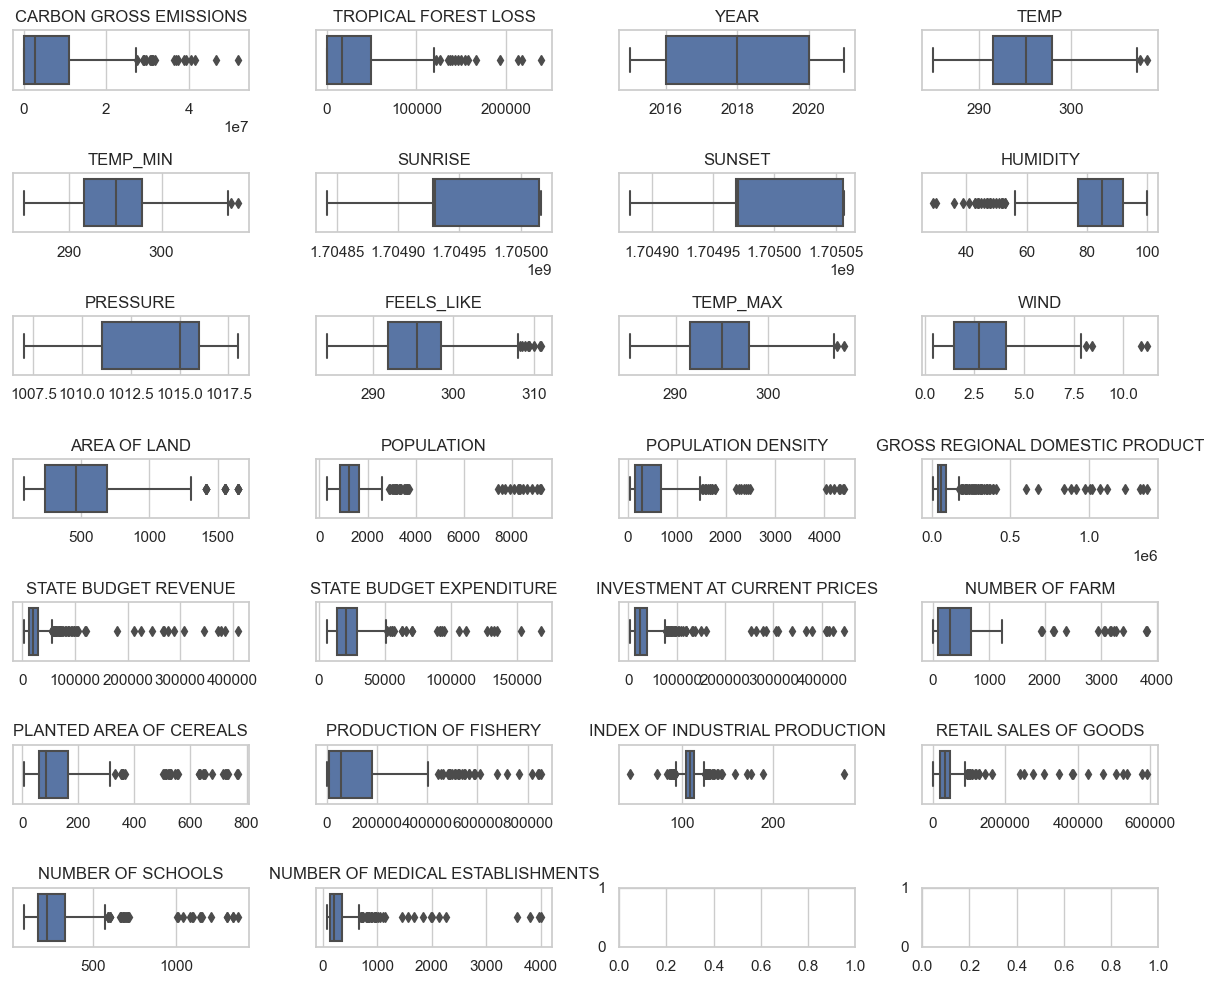

In [25]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(12, 10))
# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot boxplots for each numerical column
for i, col in enumerate(vn_feature[:len(axes)]):
    sns.boxplot(x=vn_feature[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()


In [26]:
for col in vn_feature.columns:
    z_scores = np.abs((vn_feature[col] - vn_feature[col].mean()) / vn_feature[col].std())
    total_outliers = len(vn_feature[z_scores > 3])  # Adjust the threshold (e.g., 3) based on your requirements
    print(f"Total outliers in '{col}': {total_outliers}")

Total outliers in 'CARBON GROSS EMISSIONS': 9
Total outliers in 'TROPICAL FOREST LOSS': 8
Total outliers in 'YEAR': 0
Total outliers in 'TEMP': 0
Total outliers in 'TEMP_MIN': 0
Total outliers in 'SUNRISE': 0
Total outliers in 'SUNSET': 0
Total outliers in 'HUMIDITY': 5
Total outliers in 'PRESSURE': 0
Total outliers in 'FEELS_LIKE': 0
Total outliers in 'TEMP_MAX': 0
Total outliers in 'WIND': 3
Total outliers in 'AREA OF LAND': 7
Total outliers in 'POPULATION': 14
Total outliers in 'POPULATION DENSITY': 7
Total outliers in 'GROSS REGIONAL DOMESTIC PRODUCT': 13
Total outliers in 'STATE BUDGET REVENUE': 13
Total outliers in 'STATE BUDGET EXPENDITURE': 13
Total outliers in 'INVESTMENT AT CURRENT PRICES': 14
Total outliers in 'NUMBER OF FARM': 11
Total outliers in 'PLANTED AREA OF CEREALS': 14
Total outliers in 'PRODUCTION OF FISHERY': 7
Total outliers in 'INDEX OF INDUSTRIAL PRODUCTION': 6
Total outliers in 'RETAIL SALES OF GOODS': 12
Total outliers in 'NUMBER OF SCHOOLS': 15
Total outlier

In [27]:
def handle_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column_copy = column.copy()
    column_copy.loc[column < lower_bound] = lower_bound
    column_copy.loc[column > upper_bound] = upper_bound
    return column_copy

# Create a copy of the DataFrame
vn_features_copy = vn_feature.copy()

# Apply IQR method to handle outliers for each numerical column
for col in vn_features_copy.columns:
    vn_features_copy[col] = handle_outliers_iqr(vn_features_copy[col])
vn_feature = vn_features_copy

# Verify the impact on the copied DataFrame
print("Copied DataFrame after handling outliers using IQR method:")
for col in vn_feature.columns:
    z_scores = np.abs((vn_feature[col] - vn_feature[col].mean()) / vn_feature[col].std())
    total_outliers = len(vn_feature[z_scores > 3])  # Adjust the threshold (e.g., 3) based on your requirements
    print(f"Total outliers in '{col}': {total_outliers}")

Copied DataFrame after handling outliers using IQR method:
Total outliers in 'CARBON GROSS EMISSIONS': 0
Total outliers in 'TROPICAL FOREST LOSS': 0
Total outliers in 'YEAR': 0
Total outliers in 'TEMP': 0
Total outliers in 'TEMP_MIN': 0
Total outliers in 'SUNRISE': 0
Total outliers in 'SUNSET': 0
Total outliers in 'HUMIDITY': 0
Total outliers in 'PRESSURE': 0
Total outliers in 'FEELS_LIKE': 0
Total outliers in 'TEMP_MAX': 0
Total outliers in 'WIND': 0
Total outliers in 'AREA OF LAND': 0
Total outliers in 'POPULATION': 0
Total outliers in 'POPULATION DENSITY': 0
Total outliers in 'GROSS REGIONAL DOMESTIC PRODUCT': 0
Total outliers in 'STATE BUDGET REVENUE': 0
Total outliers in 'STATE BUDGET EXPENDITURE': 0
Total outliers in 'INVESTMENT AT CURRENT PRICES': 0
Total outliers in 'NUMBER OF FARM': 0
Total outliers in 'PLANTED AREA OF CEREALS': 0
Total outliers in 'PRODUCTION OF FISHERY': 0
Total outliers in 'INDEX OF INDUSTRIAL PRODUCTION': 0
Total outliers in 'RETAIL SALES OF GOODS': 0
Tota

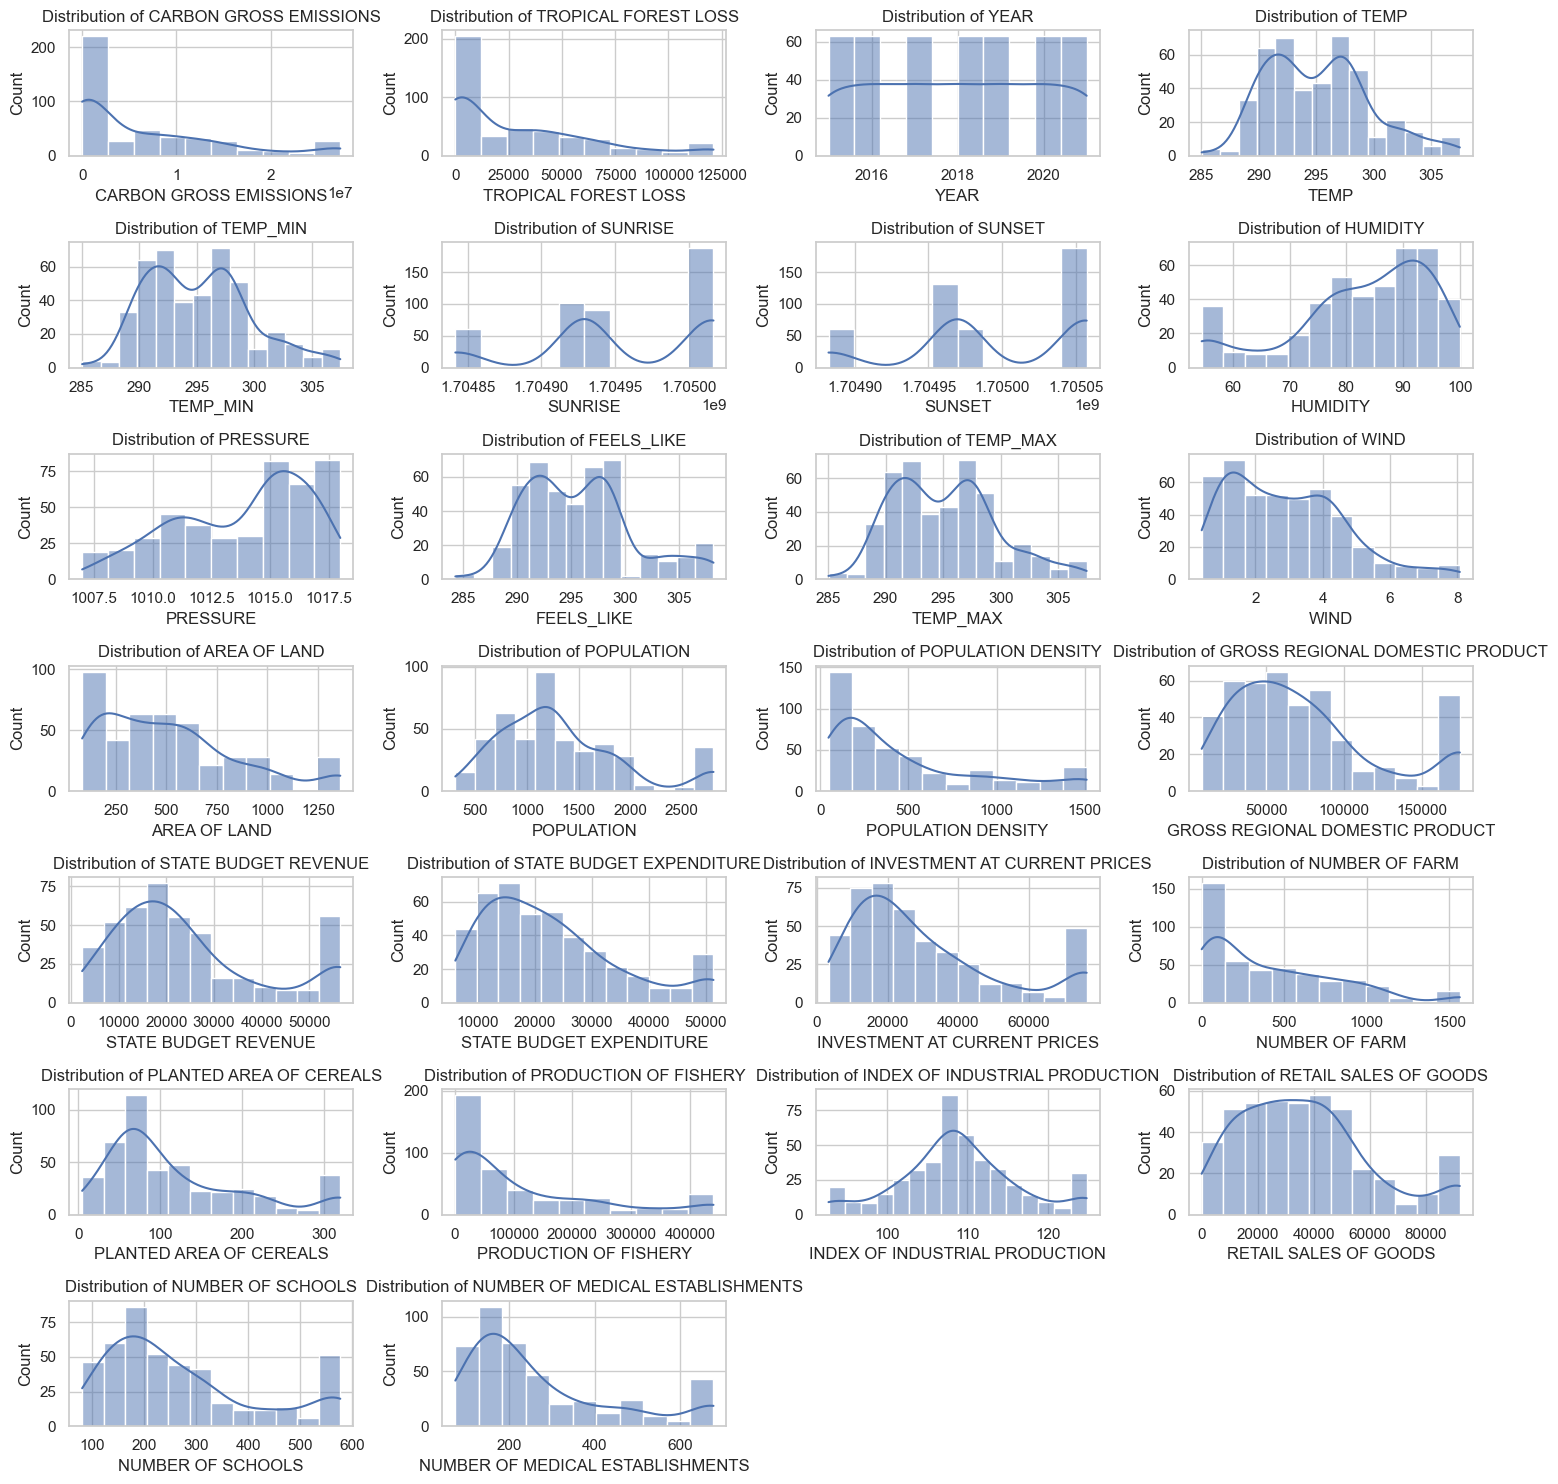

In [28]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(vn_feature, 1):
    plt.subplot(7, 4, i)
    sns.histplot(vn_feature[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [29]:
print(vn_feature.skew())

CARBON GROSS EMISSIONS              1.244390
TROPICAL FOREST LOSS                1.121528
YEAR                                0.000000
TEMP                                0.515699
TEMP_MIN                            0.515699
SUNRISE                            -0.458695
SUNSET                             -0.455978
HUMIDITY                           -0.901307
PRESSURE                           -0.490813
FEELS_LIKE                          0.636814
TEMP_MAX                            0.515699
WIND                                0.731058
AREA OF LAND                        0.867613
POPULATION                          0.972345
POPULATION DENSITY                  1.176396
GROSS REGIONAL DOMESTIC PRODUCT     0.922309
STATE BUDGET REVENUE                0.920325
STATE BUDGET EXPENDITURE            0.919559
INVESTMENT AT CURRENT PRICES        1.059732
NUMBER OF FARM                      0.998384
PLANTED AREA OF CEREALS             1.104727
PRODUCTION OF FISHERY               1.288505
INDEX OF I

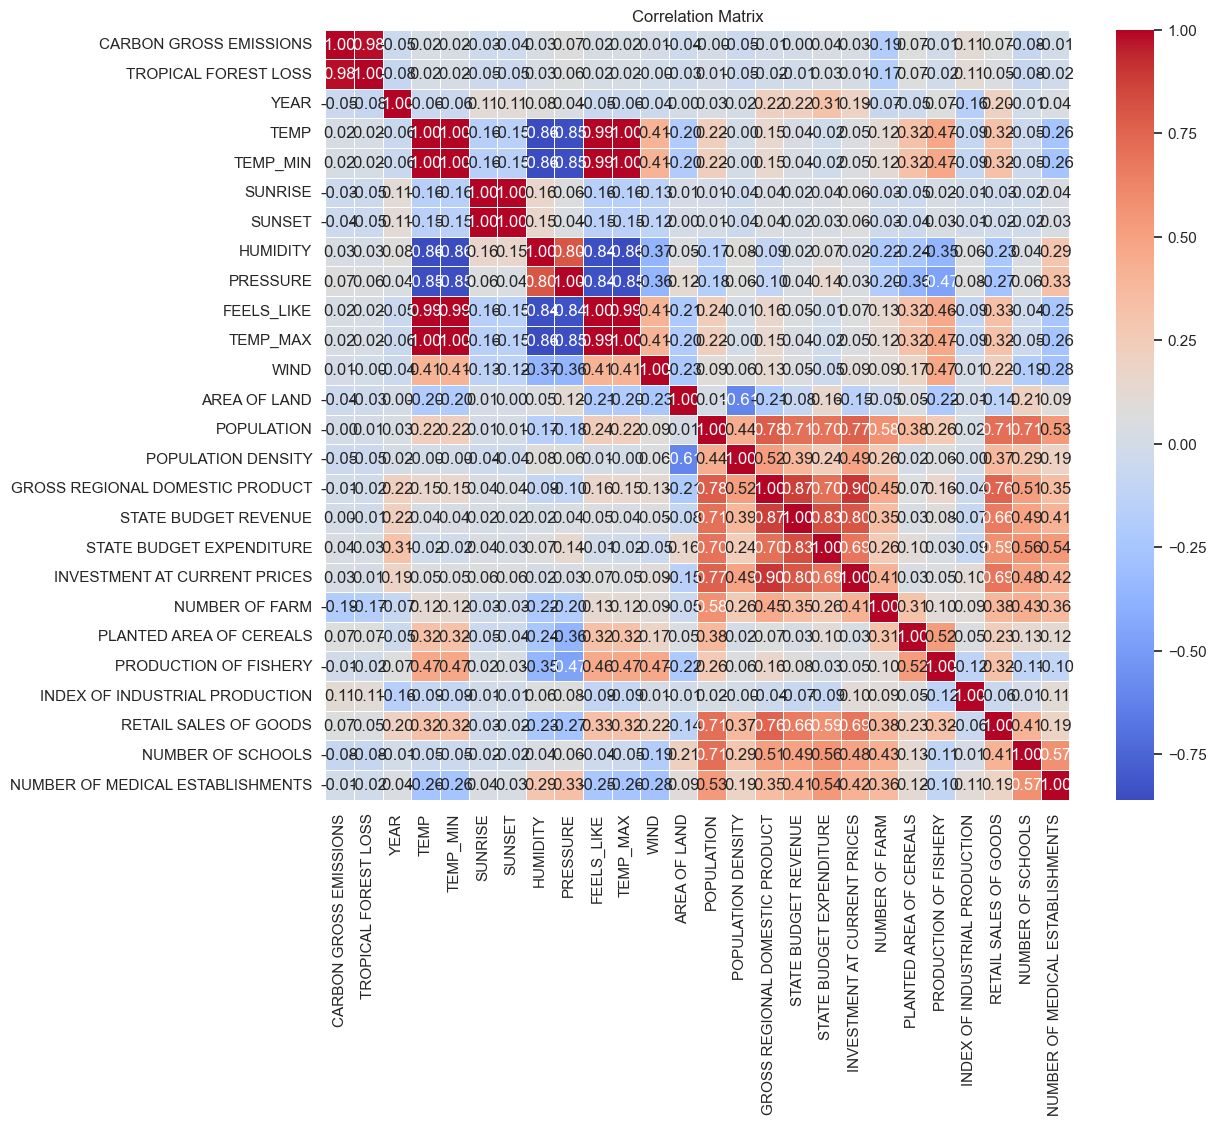

TROPICAL FOREST LOSS                1.000000
CARBON GROSS EMISSIONS              0.980667
NUMBER OF FARM                      0.173342
INDEX OF INDUSTRIAL PRODUCTION      0.108558
YEAR                                0.080968
NUMBER OF SCHOOLS                   0.076951
PLANTED AREA OF CEREALS             0.066631
PRESSURE                            0.060580
RETAIL SALES OF GOODS               0.050845
POPULATION DENSITY                  0.050654
SUNSET                              0.046421
SUNRISE                             0.045231
STATE BUDGET EXPENDITURE            0.032828
AREA OF LAND                        0.031630
HUMIDITY                            0.025166
TEMP_MAX                            0.024595
TEMP_MIN                            0.024595
TEMP                                0.024595
FEELS_LIKE                          0.023858
NUMBER OF MEDICAL ESTABLISHMENTS    0.022513
PRODUCTION OF FISHERY               0.020990
GROSS REGIONAL DOMESTIC PRODUCT     0.017107
INVESTMENT

In [30]:
correlation_matrix = vn_feature.corr()
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()
# print the correlation matrix between features and the target variable
print(correlation_matrix['TROPICAL FOREST LOSS'].abs().sort_values(ascending=False))

In [31]:
# merge the categorical column with the numerical columns
vn_feature = pd.concat([vn_feature, categorical], axis=1)
#drop duplicate columns
vn_feature = vn_feature.loc[:, ~vn_feature.columns.duplicated(keep='last')]
vn_feature.columns

Index(['CARBON GROSS EMISSIONS', 'TROPICAL FOREST LOSS', 'YEAR', 'TEMP',
       'TEMP_MIN', 'SUNRISE', 'SUNSET', 'HUMIDITY', 'PRESSURE', 'FEELS_LIKE',
       'TEMP_MAX', 'WIND', 'AREA OF LAND', 'POPULATION', 'POPULATION DENSITY',
       'GROSS REGIONAL DOMESTIC PRODUCT', 'STATE BUDGET REVENUE',
       'STATE BUDGET EXPENDITURE', 'INVESTMENT AT CURRENT PRICES',
       'NUMBER OF FARM', 'PLANTED AREA OF CEREALS', 'PRODUCTION OF FISHERY',
       'INDEX OF INDUSTRIAL PRODUCTION', 'RETAIL SALES OF GOODS',
       'NUMBER OF SCHOOLS', 'NUMBER OF MEDICAL ESTABLISHMENTS', 'DESCRIPTION'],
      dtype='object')

In [32]:
# save the transformed data
vn_feature.to_excel('../data/processed/vndata_transformed.xlsx', index=False)
# to mongodb
vn_feature.to_dict('records')
vndata_collection = 'vndata_transformed'
vndata_collection = db[vndata_collection]
vndata_collection.insert_many(vn_feature.to_dict('records'))
cursor = vndata_collection.find({})
data_list = list(cursor)
updated_data = pd.DataFrame(data_list)
print("Data successfully inserted into MongoDB collection:", vndata_collection)

Data successfully inserted into MongoDB collection: Collection(Database(MongoClient(host=['ac-crn4cg9-shard-00-02.wef2a2d.mongodb.net:27017', 'ac-crn4cg9-shard-00-00.wef2a2d.mongodb.net:27017', 'ac-crn4cg9-shard-00-01.wef2a2d.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-x2j3iu-shard-0', tls=True), 'processed_data'), 'vndata_transformed')


In [33]:
# split the data into train and test set with train = 2015 to2020 and test = 2021
train = vn_feature[vn_feature['YEAR'] < 2021]
test = vn_feature[vn_feature['YEAR'] == 2021]

# split the train and test set into X and y
X_train = train.drop(['TROPICAL FOREST LOSS'], axis=1)
y_train = train['TROPICAL FOREST LOSS']
X_test = test.drop(['TROPICAL FOREST LOSS'], axis=1)
y_test = test['TROPICAL FOREST LOSS']

In [34]:
# Create a preprocessing pipeline
pipeline = Pipeline([('scaler', StandardScaler())])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
# scale the target using standard scaler
y_train = pipeline.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = pipeline.transform(y_test.values.reshape(-1, 1)).ravel()

In [35]:
def train_and_plot_metrics(models, X_train, y_train, X_test, y_test):

    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Print metrics
        print(f'{model_name} Metrics:')
        print(f'MAE (Training): {mae_train:.2f}  |  MAE (Test): {mae_test:.2f}')
        print(f'RMSE (Training): {rmse_train:.2f}  |  RMSE (Test): {rmse_test:.2f}')
        print(f'R-squared (Training): {r2_train:.2f}  |  R-squared (Test): {r2_test:.2f}')
        print('-' * 50)

# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}

# Call the function with the specified models
train_and_plot_metrics(models, X_train, y_train, X_test, y_test)


Linear Regression Metrics:
MAE (Training): 0.12  |  MAE (Test): 0.15
RMSE (Training): 0.17  |  RMSE (Test): 0.22
R-squared (Training): 0.97  |  R-squared (Test): 0.94
--------------------------------------------------
Polynomial Regression Metrics:
MAE (Training): 0.06  |  MAE (Test): 0.46
RMSE (Training): 0.07  |  RMSE (Test): 0.63
R-squared (Training): 0.99  |  R-squared (Test): 0.47
--------------------------------------------------
Ridge Regression Metrics:
MAE (Training): 0.12  |  MAE (Test): 0.15
RMSE (Training): 0.17  |  RMSE (Test): 0.22
R-squared (Training): 0.97  |  R-squared (Test): 0.94
--------------------------------------------------
Lasso Regression Metrics:
MAE (Training): 0.82  |  MAE (Test): 0.72
RMSE (Training): 1.00  |  RMSE (Test): 0.88
R-squared (Training): 0.00  |  R-squared (Test): -0.04
--------------------------------------------------
Decision Tree Regressor Metrics:
MAE (Training): 0.00  |  MAE (Test): 0.12
RMSE (Training): 0.00  |  RMSE (Test): 0.21
R-squa

In [36]:
params = {
    "max_depth": range(1,12),
    "min_samples_split": range(2,20),
    "min_samples_leaf": range(1,20),
    "criterion": ('absolute_error', 'squared_error', 'friedman_mse'),
    "splitter": ("best", "random"),
}
tree2 = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(estimator=tree2, param_grid=params)
grid.fit(X_train, y_train)
print("best params:", grid.best_params_)


best params: {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 17, 'splitter': 'random'}


In [37]:
def find_max_leaf_node(Xtrain, ytrain):
    max_leaf_nodes = []
    # loop through the range of 2 to 100
    for i in range(2, 100):
        tree = DecisionTreeRegressor(max_leaf_nodes=i, random_state=0)
        tree.fit(Xtrain, ytrain)
        max_leaf_nodes.append(tree.tree_.node_count)
    return max_leaf_nodes
max_leaf_node = find_max_leaf_node(X_train, y_train)
print(max(max_leaf_node))

197


In [38]:
model = grid.best_estimator_
print(grid.best_params_)
model.fit(X_train, y_train)
# predict and print the rmse, r2 and mae
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


{'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 17, 'splitter': 'random'}
RMSE: 0.22952212601736496
R2: 0.9295052813242853
MAE: 0.14545722966098776


In [39]:
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
print("CCP Alphas: ", ccp_alphas)
clfs = []
for ccp_alpha in ccp_alphas:
    tree3 = DecisionTreeRegressor(random_state=420, ccp_alpha=ccp_alpha)
    tree3.fit(X_train, y_train)
    clfs.append(tree3)


CCP Alphas:  [0.00000000e+00 3.86930134e-09 2.44776152e-08 3.93287928e-07
 5.61555856e-07 5.68281342e-06 8.74504298e-06 3.25423984e-05
 1.61201198e-04 1.87646430e-04 2.45307618e-04 2.71812766e-04
 3.39537531e-04 5.07114224e-04 6.23487611e-04 6.25535660e-04
 6.75854567e-04 9.34158501e-04 1.00005249e-03 1.08745548e-03
 1.30261606e-03 1.62950199e-03 1.63593232e-03 2.40947025e-03
 2.58675430e-03 5.53556439e-03 1.01523157e-02 1.46781058e-02
 1.64897627e-02 4.09635544e-02 2.51690173e-01 6.12943434e-01]


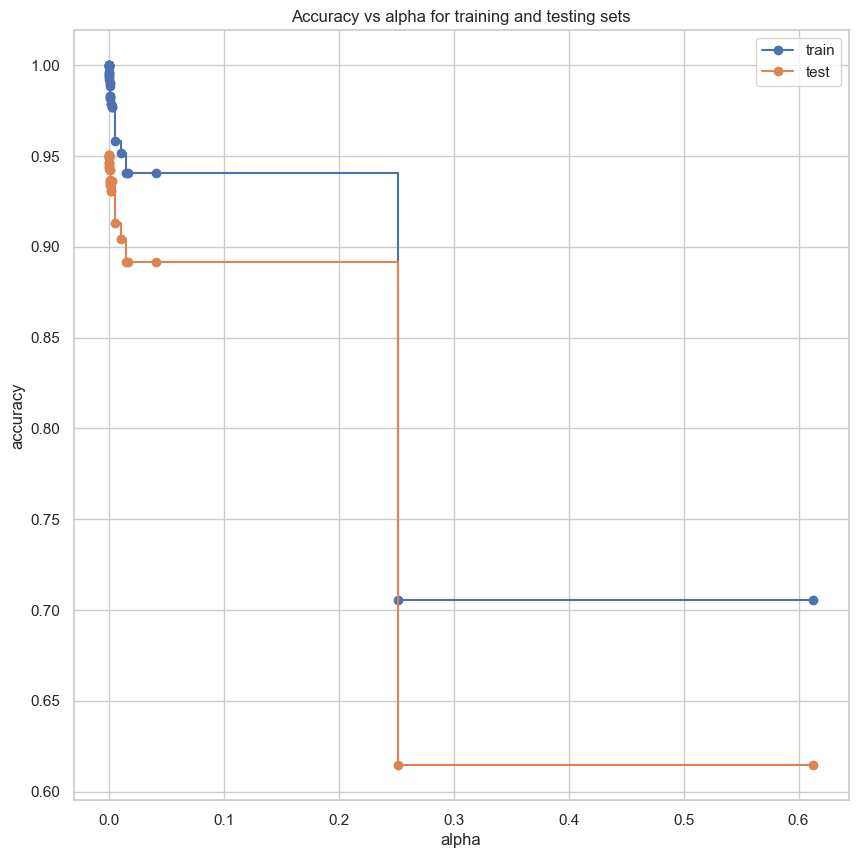

In [40]:
#  plot the result for each alphas and impurities
train_scores = [tree3.score(X_train, y_train) for tree3 in clfs]
test_scores = [tree3.score(X_test, y_test) for tree3 in clfs]
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

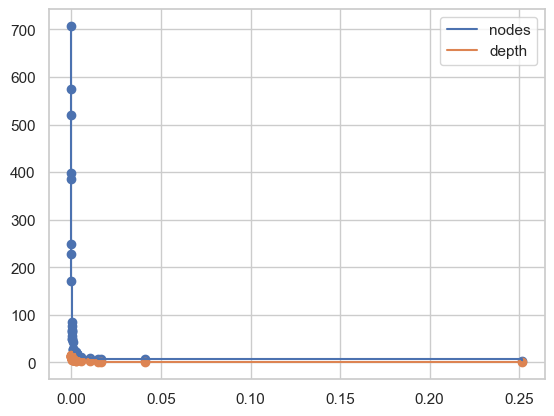

In [41]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()


--> alpas : 8.61255641e-03
best params: {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 19, 'splitter': 'random'}
max_leaf_node = 197


In [42]:
LastTree = DecisionTreeRegressor(ccp_alpha=8.61255641e-03,          
                                  max_depth=6, 
                                  criterion='squared_error',
                                  splitter='random',
                                  min_samples_leaf= 6,
                                  min_samples_split= 10,
                                  max_leaf_nodes=197,
                                  )

LastTree.fit(X_train, y_train)
LasTrainPred= LastTree.predict(X_train)
LastTestPred= LastTree.predict(X_test)

# print r2, mae and rmse 
print("R2 test:", r2_score(y_test, LastTestPred))
print("MAE test:", mean_absolute_error(y_test, LastTestPred))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, LastTestPred)))
# for the train set 
print("R2 train:", r2_score(y_train, LasTrainPred))
print("MAE train:", mean_absolute_error(y_train, LasTrainPred))
print("RMSE train:", np.sqrt(mean_squared_error(y_train, LasTrainPred)))


R2 test: 0.8862879971833583
MAE test: 0.20818177426299575
RMSE test: 0.2915072910444186
R2 train: 0.9483138565301629
MAE train: 0.17130303334237254
RMSE train: 0.22734586750112068
